In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from time import time
import json
import sys

from thorr.utils import read_config

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score

from sklearn.model_selection import KFold, ShuffleSplit, RepeatedKFold, train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.inspection import permutation_importance

from joblib import dump, load

from permetrics.regression import RegressionMetric
from scipy import stats

In [2]:
config_path = Path('/Users/gdarkwah/Library/CloudStorage/OneDrive-UW/01-Research/03-HAB/.env/hab_config.ini')
config_dict = read_config(config_path)
project_dir = Path(config_dict["project"]["project_dir"])

seed = 1955

test_size = 0.2
n_splits = 5
n_repeats = 10

In [3]:
hls_insitu = pd.read_csv(project_dir / 'data/hls_insitu/hls_insitu.csv', low_memory=False)
hls_insitu['Date'] = pd.to_datetime(hls_insitu['Date'])
hls_insitu['log_chl_a'] = np.log10(hls_insitu['chl_a'])

In [4]:
# find the mean, median and mode of chl_a
mean_chl_a = hls_insitu['chl_a'].mean()
median_chl_a = hls_insitu['chl_a'].median()
mode_chl_a = hls_insitu['chl_a'].mode()[0]

# find the mean, median and mode of log_chl_a
mean_log_chl_a = hls_insitu['log_chl_a'].mean()
median_log_chl_a = hls_insitu['log_chl_a'].median()
mode_log_chl_a = hls_insitu['log_chl_a'].mode()[0]
std_log_chl_a = hls_insitu['log_chl_a'].std()

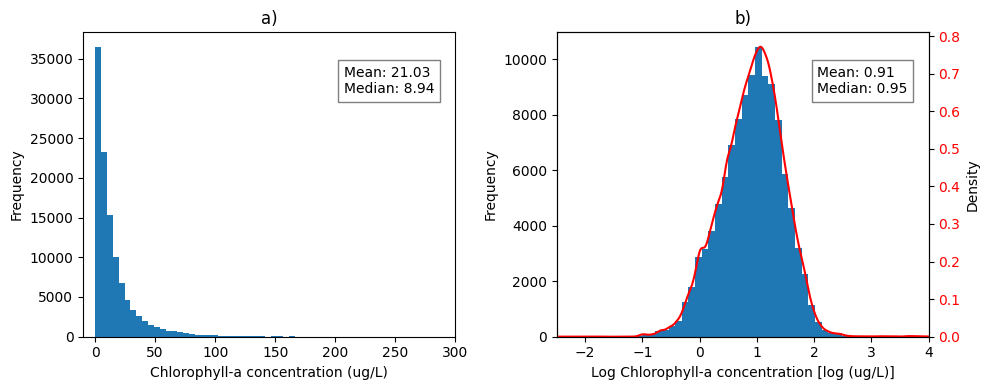

In [5]:
# plot plot kde and histogram of chl_a log scales
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(10,4))
# ax2 = ax1.twinx()
ax4 = ax3.twinx()

hls_insitu['chl_a'].plot.hist(bins=2000, ax=ax1)
# hls_insitu['chl_a'].plot.kde(ax=ax2, color='red')
hls_insitu['log_chl_a'].plot.hist(bins=50, ax=ax3)
hls_insitu['log_chl_a'].plot.kde(ax=ax4, color='red')

# make both twin axes start from 0
ax1.set_ylim(bottom=0)
# ax2.set_ylim(bottom=0)
ax3.set_ylim(bottom=0)
ax4.set_ylim(bottom=0)
# make x axis log scale
ax1.set_xlabel('Chlorophyll-a concentration (ug/L)')
# set x axis limits
ax1.set_xlim([-10, 300])
ax3.set_xlabel('Log Chlorophyll-a concentration [log (ug/L)]')
# set x axis limits
ax3.set_xlim([-2.5, 4])

ax4.tick_params(axis='y', labelcolor='red')
ax1.set_title('a)')
ax3.set_title('b)')

# annotate mean, median and mode on both plots. add text instead of lines
ax1.text(0.7, 0.8, f'Mean: {mean_chl_a:.2f}\nMedian: {median_chl_a:.2f}', transform=ax1.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
ax3.text(0.7, 0.8, f'Mean: {mean_log_chl_a:.2f}\nMedian: {median_log_chl_a:.2f}', transform=ax3.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

fig.tight_layout()
fig.savefig('chl_a_distribution.png', dpi=300)


## Oversampling

Approach:
1. select only the data within three standard deviations of from the mean.
2. Divide the data into a number of bins
3. For each bin, bootstrap the samples with repition. The size of the bigest bin will be the target size of all the other bins

In [6]:
hls_insitu.dropna(subset=['chl_a'], inplace=True)
hls_insitu.to_csv(project_dir / 'data/hls_insitu/hls_insitu_chl_a_clean.csv', index=False)

In [7]:
bins = np.logspace(mean_log_chl_a - 3 * std_log_chl_a, mean_log_chl_a + 3 * std_log_chl_a, 50) # using logarithmic bins from mean - 3*std to mean + 3*std
oversampled_data.dropna(subset=['chl_a'], inplace=True)

oversampled_data['bin'] = pd.cut(oversampled_data['chl_a'], bins=bins)

In [10]:
mean_log_chl_a + 3 * std_log_chl_a

np.float64(2.5432573909695426)

In [8]:
# how many unique bins are there?
print(f'Number of unique bins: {oversampled_data["bin"].nunique()}')

Number of unique bins: 49


In [9]:
# What is the bin with the largest number of samples?
bin_counts = oversampled_data['bin'].value_counts()
print(f'Bin with the largest number of samples: {bin_counts.idxmax()} with {bin_counts.max()} samples')

Bin with the largest number of samples: (11.977, 13.962] with 5882 samples


In [11]:
oversampled_data_list = []

for bin in oversampled_data['bin'].unique():
    bin_data = oversampled_data[oversampled_data['bin'] == bin]
    n_samples = bin_counts.max() # required samples in each bin
    # if (len(bin_data) < n_samples) and (len(bin_data) > 0):
    #     # if there are less than 100 samples in the bin, resample with replacement to get 100 samples
    #     resampled_bin_data = bin_data.sample(n=n_samples, replace=True, random_state=seed)
    # else:
    #     resampled_bin_data = bin_data
    
    if len(bin_data) > 0:
        oversampled_data_list.append(bin_data.sample(n=n_samples, replace=True, random_state=seed))

oversampled_data = pd.concat(oversampled_data_list, ignore_index=True)
del oversampled_data_list

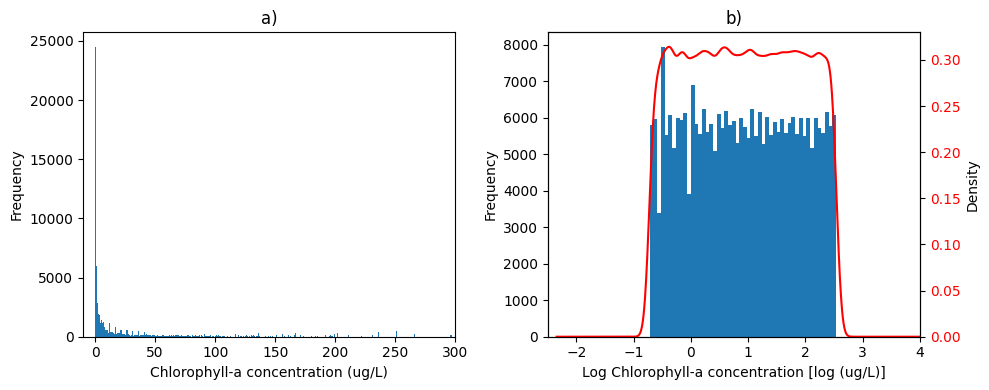

In [12]:
# plot plot kde and histogram of chl_a log scales
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(10,4))
# ax2 = ax1.twinx()
ax4 = ax3.twinx()

oversampled_data['chl_a'].plot.hist(bins=2000, ax=ax1)
# oversampled_data['chl_a'].plot.kde(ax=ax2, color='red')
oversampled_data['log_chl_a'].plot.hist(bins=50, ax=ax3)
oversampled_data['log_chl_a'].plot.kde(ax=ax4, color='red')

# make both twin axes start from 0
ax1.set_ylim(bottom=0)
# ax2.set_ylim(bottom=0)
ax3.set_ylim(bottom=0)
ax4.set_ylim(bottom=0)
# make x axis log scale
ax1.set_xlabel('Chlorophyll-a concentration (ug/L)')
# set x axis limits
ax1.set_xlim([-10, 300])
ax3.set_xlabel('Log Chlorophyll-a concentration [log (ug/L)]')
# set x axis limits
ax3.set_xlim([-2.5, 4])

ax4.tick_params(axis='y', labelcolor='red')
ax1.set_title('a)')
ax3.set_title('b)')


fig.tight_layout()
fig.savefig('chl_a_distribution.png', dpi=300)


In [ ]:
oversampled_data.drop(columns=['bin'], inplace=True)
oversampled_data.to_csv(project_dir / 'data/hls_insitu/oversampled_train.csv', index=False)
test_set.to_csv(project_dir / 'data/hls_insitu/test_set.csv', index=False)
val_set
del oversampled_data